# VQC, SVM, and Feature Map

The contents of this notebook are strongly based on the following paper:
https://arxiv.org/pdf/1804.11326.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import FeatureMap
%matplotlib inline

def expectationZBasis(counts, shots):
    expectation = 0
    for key in counts:
        sign = 1
        if key.count("1") % 2 == 1:
            sign = -1
        expectation += sign * counts[key] / shots
    return expectation

## Feature Maps

In [2]:
def MyZFeatureMap(qubits, x, numMeasurements=None, invert=False):
    if np.sum(np.iscomplex(x)) != 0:
        raise Exception("x must be real in the feature map encoding")
    if numMeasurements is None:
        numMeasurements = qubits
    
    if numMeasurements == 0:
        circ = QuantumCircuit(qubits)
    else:
        circ = QuantumCircuit(qubits, numMeasurements)
    if invert:
        for i in range(qubits):
            circ.p(-2*x[i], i)
            circ.h(i)
            circ.p(-2*x[i], i)
            circ.h(i)
        return circ
    for i in range(qubits):
        circ.h(i)
        circ.p(2*x[i], i)
        circ.h(i)
        circ.p(2*x[i], i)
    return circ

def MyZZFeatureMap(qubits, x, numMeasurements=None, invert=False):
    if np.sum(np.iscomplex(x)) != 0:
        raise Exception("x must be real in this feature map encoding")
    if numMeasurements is None:
        numMeasurements = qubits
        
    if numMeasurements == 0:
        circ = QuantumCircuit(qubits)
    else:
        circ = QuantumCircuit(qubits, numMeasurements)
    
    if invert:
        for i in reversed(range(qubits-1)):
            circ.cx(i, i+1)
            circ.p(-2*(np.pi-x[i])*(np.pi-x[i+1]), i+1)
            circ.cx(i, i+1)
        
        for i in range(qubits):
            circ.p(-2*x[i], i)
            circ.h(i)
        return circ
    
    for i in range(qubits):
        circ.h(i)
        circ.p(2*x[i], i) # TODO Check p gate is the same as the u1 gate
    
    for i in range(qubits-1):
        circ.cx(i, i+1)
        circ.p(2*(np.pi - x[i])*(np.pi - x[i+1]), i+1)
        circ.cx(i, i+1)
    
    return circ
    
# There may be a better name for this
def MyRyFeatureMap(qubits, x, numMeasurements=None, invert=False):
    if np.sum(np.iscomplex(x)) != 0:
        raise Exception("x must be real in the feature map encoding")
    if numMeasurements is None:
        numMeasurements = qubits
        
    if numMeasurements == 0:
        circ = QuantumCircuit(qubits)
    else:
        circ = QuantumCircuit(qubits, numMeasurements)
    
    if invert:
        for i in range(qubits):
            circ.ry(-2*x[i], i)
        return circ
    
    for i in range(qubits):
        circ.ry(2*x[i], i)
    return circ

{'0': 32768}


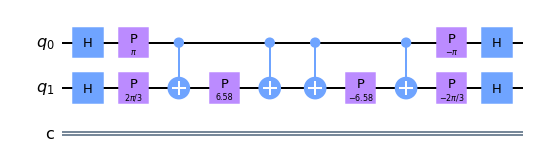

In [3]:
# Testing inverse
circ = MyZZFeatureMap(2, np.array([np.pi/2, np.pi/3]), numMeasurements=1) + MyZZFeatureMap(2, np.array([np.pi/2, np.pi/3]), numMeasurements=1, invert=True)
backend = Aer.get_backend("qasm_simulator")

job = execute(circ, backend, shots=2**15)
res = job.result()
counts = res.get_counts()
print(counts)
circ.draw('mpl')

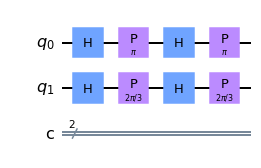

In [4]:
fmap = MyZFeatureMap(2, np.array([np.pi/2, np.pi/3]))
fmap.draw('mpl')

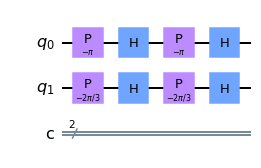

In [5]:
fmap = MyZFeatureMap(2, np.array([np.pi/2, np.pi/3]), invert=True)
fmap.draw('mpl')

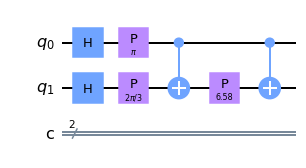

In [6]:
fmap = MyZZFeatureMap(2, np.array([np.pi/2, np.pi/3]))
fmap.draw('mpl')

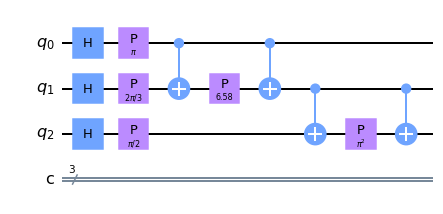

In [7]:
fmap = MyZZFeatureMap(3, np.array([np.pi/2, np.pi/3, np.pi/4]))
fmap.draw('mpl')

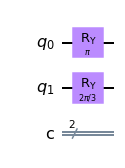

In [8]:
fmap = MyRyFeatureMap(2, np.array([np.pi/2, np.pi/3]))
fmap.draw('mpl')

## VQC

In [9]:
def U(theta, layer, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    if layer >= layers:
        raise Exception("Layer {} is greater than number of layers!".format(layer))
    
    if numMeasurements is None:
        numMeasurements = qubits
    
    circ = QuantumCircuit(qubits, numMeasurements)
    for q in range(qubits):
        circ.ry(theta[0][q][layer], q)
        circ.rz(theta[1][q][layer], q)
    return circ

def U_ent(qubits, numMeasurements=None):
    if qubits < 2:
        raise Exception("Not enough qubits to create U_ent")
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    
    for i in range(qubits-1):
        circ.cz(i, i+1)
    
    if qubits != 2:
        circ.cz(qubits-1, 0) # TODO Check, this may be qc.cz(0, qubits-1)
    return circ

def buildCircuit(theta, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    for i in range(layers-1):
        circ += U(theta, i, numMeasurements)
        circ += U_ent(qubits, numMeasurements)
    circ += U(theta, layers-1, numMeasurements)
    
    # Add Measurments
    circ.measure(range(numMeasurements), range(numMeasurements))
    
    return circ

Theta:
[[[-0.06808208 -0.63248657 -0.54689115  0.92720859]
  [-0.12057902  2.66538763 -0.86577825 -0.29458637]]

 [[-0.93871026  2.12334538  0.98618285 -0.46631184]
  [-0.59604971 -0.68296398 -1.3672856  -1.1801269 ]]]


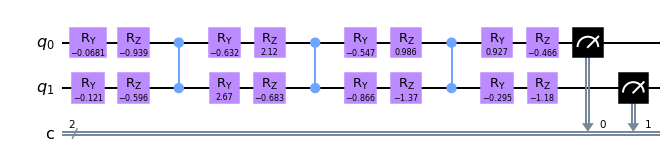

In [10]:
qubits = 2
layers = 4
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")

Theta:
[[[-0.28986631 -1.35209727  1.17858241 -0.25714777  0.35194443]
  [-0.99762187  0.78369619  0.11846972 -0.47420729 -0.80356188]
  [-1.18187129 -0.12023504  0.3264633  -1.93779692  0.62698482]]

 [[-0.80930914  0.69090277  0.14572941 -0.83860281  0.1465699 ]
  [-0.98512298  2.22268138  0.90306473  0.29436641  0.46879246]
  [ 1.94654236  1.31242179  2.13320828 -0.51694318 -1.26973566]]]


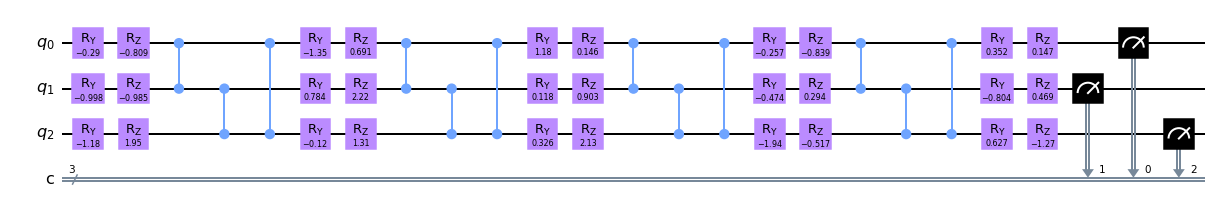

In [11]:
qubits = 3
layers = 5
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")

### Training

In [12]:
def f(theta, bias, x, featureMap, shots=2048):
    rotations, qubits, layers = theta.shape
    circ = featureMap(qubits, x) + buildCircuit(theta)
    
    # Run the quantum circuit
    backend = Aer.get_backend("qasm_simulator")
    
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    return expectationZBasis(counts, shots) + bias

def classify(theta, bias, x, featureMap, shots=2048):
    return 1 if f(theta, bias, x, shots) > 0 else -1

In [13]:
def MSELoss(yhats, ys, shots=2048):
    if len(yhats) != len(ys):
        raise Exception("Length of yhats must match length of ys")
    return np.sum((yhats - ys)**2)/len(ys)

def gradF(theta, maskTheta, bias, maskBias, x, featureMap, shots=2048, r=0.5):
    return r*(f(theta+maskTheta, bias+maskBias, x, featureMap, shots) - f(theta-maskTheta, bias-maskBias, x, featureMap, shots))

def gradMSE_theta(theta, bias, x, yhat, y, featureMap, shots=2048, r=0.5):
    s = np.pi/(4*r)
    grad = np.zeros_like(theta)
    mask = np.zeros_like(theta)
    for i in range(len(theta)):
        for j in range(len(theta[i])):
            for k in range(len(theta[i][j])):
                mask[i][j][k] = s
                func = lambda ind: 2*(yhat[ind] - y[ind])*gradF(theta, mask, bias, 0, x[ind], featureMap, shots=shots, r=r)
                grad[i][j][k] = np.sum(np.vectorize(func)(np.arange(len(x))))
                mask[i][j][k] = 0
    return grad/len(x)

def gradMSE_b(theta, bias, x, yhat, y, featureMap, shots=2048, r=0.5):
    s = np.pi/(4*r)
    mask = np.zeros_like(theta)
    func = lambda ind: 2*(yhat[ind] - y[ind])*gradF(theta, mask, bias, s, x[ind], featureMap, shots, r)
    return np.sum(np.vectorize(func)(np.arange(len(x))))/len(x)

def train(x, y, featureMap, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048):
    theta = np.random.rand(2, qubits, layers)
    b = np.random.rand()
    
    for epoch in range(numEpochs):
        func = lambda x: f(theta, b, x, featureMap, shots)
        yhat = np.apply_along_axis(func, 1, x)
        if epoch % 5 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, MSELoss(yhat, y, shots)))
        gradTheta = gradMSE_theta(theta, b, x, yhat, y, featureMap, shots)
        gradB = gradMSE_b(theta, b, x, yhat, y, featureMap, shots)
        theta = theta - eta*gradTheta
        b = b - eta*gradB
    return theta, b

## Breast Cancer Dataset

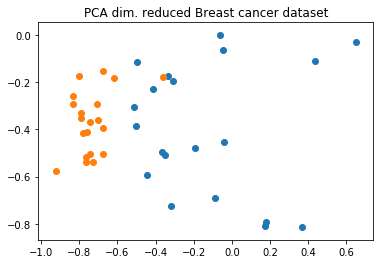

In [14]:
from qiskit.ml.datasets import breast_cancer

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)
v_datapoints, _ = split_dataset_to_data_and_labels(test_input)

In [15]:
x = datapoints[0]
y = datapoints[1]
y[y == 0] = -1
order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [16]:
v_x = v_datapoints[0]
v_y = v_datapoints[1]
v_y[v_y == 0] = -1
order = np.arange(len(v_x))
np.random.shuffle(order)
v_x = v_x[order]
v_y = v_y[order]

In [17]:
SEED = 123

In [16]:
# Base
np.random.seed(SEED)
theta, b = train(x, y, MyRyFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyRyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 2.0901513616321714
Epoch: 5, Loss: 2.062590424093932
Epoch: 10, Loss: 2.023743947364031
Epoch: 15, Loss: 1.978386470241127
Epoch: 20, Loss: 1.9262425005376833
Epoch: 25, Loss: 1.9077119404226992
Epoch: 30, Loss: 1.8639618505389373
Epoch: 35, Loss: 1.8243588082079598
Epoch: 40, Loss: 1.7754732245111016
Epoch: 45, Loss: 1.736148781053377
Epoch: 50, Loss: 1.70868824083914
Epoch: 55, Loss: 1.6805641262025144
Epoch: 60, Loss: 1.652994202122913
Epoch: 65, Loss: 1.6163070087953286
Epoch: 70, Loss: 1.6045322338068235
Epoch: 75, Loss: 1.563120617441956
Epoch: 80, Loss: 1.5268719372715704
Epoch: 85, Loss: 1.4960419961419633
Epoch: 90, Loss: 1.4829324963699193
Epoch: 95, Loss: 1.4563741592463928
Test Loss: 1.4148769470280376


In [17]:
# Increase eta
np.random.seed(SEED)
theta, b = train(x, y, MyRyFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyRyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 2.105640216919632
Epoch: 5, Loss: 1.7086954005818875
Epoch: 10, Loss: 1.435469810092398
Epoch: 15, Loss: 1.1983046184159225
Epoch: 20, Loss: 1.0394865862221132
Epoch: 25, Loss: 0.8944648317163656
Epoch: 30, Loss: 0.8091029051435953
Epoch: 35, Loss: 0.740696665361487
Epoch: 40, Loss: 0.6930634418900136
Epoch: 45, Loss: 0.64920339326619
Epoch: 50, Loss: 0.6157664150561338
Epoch: 55, Loss: 0.587994335360189
Epoch: 60, Loss: 0.5690611644071145
Epoch: 65, Loss: 0.5492407071197087
Epoch: 70, Loss: 0.5434783530581777
Epoch: 75, Loss: 0.5359138689388224
Epoch: 80, Loss: 0.5268933497369577
Epoch: 85, Loss: 0.5106597603632427
Epoch: 90, Loss: 0.5082033676377472
Epoch: 95, Loss: 0.5085604679139581
Test Loss: 0.47801224028909745


In [18]:
# Increase the number of layers to 3, keep increased eta
np.random.seed(SEED)
theta, b = train(x, y, MyRyFeatureMap, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 3 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyRyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.6079165122631167
Epoch: 5, Loss: 1.3638598566108158
Epoch: 10, Loss: 1.214004556701915
Epoch: 15, Loss: 1.1293660480818668
Epoch: 20, Loss: 1.0601910222453632
Epoch: 25, Loss: 1.0053767718260338
Epoch: 30, Loss: 0.9608911685933418
Epoch: 35, Loss: 0.9405596336326004
Epoch: 40, Loss: 0.9030671101999758
Epoch: 45, Loss: 0.8760223716161875
Epoch: 50, Loss: 0.8515163613355465
Epoch: 55, Loss: 0.8364686793595155
Epoch: 60, Loss: 0.8076671137676084
Epoch: 65, Loss: 0.7962388070773269
Epoch: 70, Loss: 0.7752880177139243
Epoch: 75, Loss: 0.7532443391754269
Epoch: 80, Loss: 0.7446959445522933
Epoch: 85, Loss: 0.7128979159269054
Epoch: 90, Loss: 0.6813751998313917
Epoch: 95, Loss: 0.6834071391107015
Test Loss: 0.714745967267324


In [19]:
# Increase the number of layers to 4, keep increased eta
np.random.seed(SEED)
theta, b = train(x, y, MyRyFeatureMap, qubits=2, layers=4, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 4 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyRyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.0911103992014772
Epoch: 5, Loss: 1.012497427163529
Epoch: 10, Loss: 0.9615689037303223
Epoch: 15, Loss: 0.8917474625377991
Epoch: 20, Loss: 0.8649859911945054
Epoch: 25, Loss: 0.8338761190705266
Epoch: 30, Loss: 0.7941047114180873
Epoch: 35, Loss: 0.7678157920580218
Epoch: 40, Loss: 0.7405543662489782
Epoch: 45, Loss: 0.7098363524692447
Epoch: 50, Loss: 0.6949822362807645
Epoch: 55, Loss: 0.6702491731394498
Epoch: 60, Loss: 0.6467526075580474
Epoch: 65, Loss: 0.6238442090109448
Epoch: 70, Loss: 0.6072567534813403
Epoch: 75, Loss: 0.5938107482688494
Epoch: 80, Loss: 0.572181593093152
Epoch: 85, Loss: 0.5655771211067702
Epoch: 90, Loss: 0.5446178460894892
Epoch: 95, Loss: 0.5280957669286884
Test Loss: 0.5656598019033234


In [20]:
# Different feature map results with eta = 1e-2
np.random.seed(SEED)
theta, b = train(x, y, MyZFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.4714654458138425
Epoch: 5, Loss: 1.4159201544949152
Epoch: 10, Loss: 1.3726609050063587
Epoch: 15, Loss: 1.3369539254652554
Epoch: 20, Loss: 1.3077685839587245
Epoch: 25, Loss: 1.2849053409659164
Epoch: 30, Loss: 1.2570522452575008
Epoch: 35, Loss: 1.240305567441418
Epoch: 40, Loss: 1.221169486821834
Epoch: 45, Loss: 1.1974735267628607
Epoch: 50, Loss: 1.193495061208028
Epoch: 55, Loss: 1.1731246358392071
Epoch: 60, Loss: 1.159091530541517
Epoch: 65, Loss: 1.1241903852361341
Epoch: 70, Loss: 1.1121375331439762
Epoch: 75, Loss: 1.097116752523038
Epoch: 80, Loss: 1.0769535048424905
Epoch: 85, Loss: 1.0645269851375674
Epoch: 90, Loss: 1.0548843462082425
Epoch: 95, Loss: 1.0315270604503435
Test Loss: 1.1130854145813778


In [21]:
# Different feature map results with eta = 1e-2 and 3 layers
np.random.seed(SEED)
theta, b = train(x, y, MyZFeatureMap, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 3 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.0816890470643095
Epoch: 5, Loss: 1.047368029065177
Epoch: 10, Loss: 1.0299967922160227
Epoch: 15, Loss: 1.0026172872106978
Epoch: 20, Loss: 0.9854905993766347
Epoch: 25, Loss: 0.9565781540484931
Epoch: 30, Loss: 0.9487280068249083
Epoch: 35, Loss: 0.9202958768677068
Epoch: 40, Loss: 0.8896376749470007
Epoch: 45, Loss: 0.886583208666712
Epoch: 50, Loss: 0.8615046386115438
Epoch: 55, Loss: 0.8472090022612235
Epoch: 60, Loss: 0.8314561851202562
Epoch: 65, Loss: 0.8088270181280517
Epoch: 70, Loss: 0.799551253814148
Epoch: 75, Loss: 0.7806573417745029
Epoch: 80, Loss: 0.7734270130467769
Epoch: 85, Loss: 0.7596275117064435
Epoch: 90, Loss: 0.7389750465103001
Epoch: 95, Loss: 0.7141202604371973
Test Loss: 0.7171786891690233


In [22]:
# Different feature map results with eta = 1e-2 and 4 layers
np.random.seed(SEED)
theta, b = train(x, y, MyZFeatureMap, qubits=2, layers=4, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 4 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.0249765974102565
Epoch: 5, Loss: 0.9303879062744844
Epoch: 10, Loss: 0.8628886525420292
Epoch: 15, Loss: 0.8421969649684755
Epoch: 20, Loss: 0.8117924385518744
Epoch: 25, Loss: 0.7791830610713946
Epoch: 30, Loss: 0.7628906518590454
Epoch: 35, Loss: 0.744103093802509
Epoch: 40, Loss: 0.7275776630487373
Epoch: 45, Loss: 0.7160601127926508
Epoch: 50, Loss: 0.6949300443372144
Epoch: 55, Loss: 0.6654891720080436
Epoch: 60, Loss: 0.656039159029917
Epoch: 65, Loss: 0.6351628697510578
Epoch: 70, Loss: 0.6245513576657361
Epoch: 75, Loss: 0.6121936075456604
Epoch: 80, Loss: 0.5983372823085846
Epoch: 85, Loss: 0.5865150173861317
Epoch: 90, Loss: 0.5813821758125293
Epoch: 95, Loss: 0.5625333542916533
Test Loss: 0.582216183917742


In [23]:
# ZZ feature map results with eta = 1e-2
np.random.seed(SEED)
theta, b = train(x, y, MyZZFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.3284879300612062
Epoch: 5, Loss: 1.2645134703330396
Epoch: 10, Loss: 1.1917038913383202
Epoch: 15, Loss: 1.1490072668374716
Epoch: 20, Loss: 1.0962818592920083
Epoch: 25, Loss: 1.0750171634258012
Epoch: 30, Loss: 1.0584420156931402
Epoch: 35, Loss: 1.029022789920196
Epoch: 40, Loss: 1.0184403049743076
Epoch: 45, Loss: 0.9972600497440783
Epoch: 50, Loss: 0.9932514791759782
Epoch: 55, Loss: 0.9793735111927748
Epoch: 60, Loss: 0.9704239581285549
Epoch: 65, Loss: 0.969907786231811
Epoch: 70, Loss: 0.9526384891730011
Epoch: 75, Loss: 0.9425376766152234
Epoch: 80, Loss: 0.937513635312255
Epoch: 85, Loss: 0.9332937756869495
Epoch: 90, Loss: 0.9193441851594926
Epoch: 95, Loss: 0.9154239239845019
Test Loss: 1.076990742515849


In [24]:
# ZZ feature map results with eta = 1e-2, 3 layers
np.random.seed(SEED)
theta, b = train(x, y, MyZZFeatureMap, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 3 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.3601878759129822
Epoch: 5, Loss: 1.2008567598423747
Epoch: 10, Loss: 1.0681288881899058
Epoch: 15, Loss: 0.9933507946161397
Epoch: 20, Loss: 0.9152752029593969
Epoch: 25, Loss: 0.8498553621195845
Epoch: 30, Loss: 0.8129890880809529
Epoch: 35, Loss: 0.7736052860567647
Epoch: 40, Loss: 0.7420627371017
Epoch: 45, Loss: 0.7178542990604366
Epoch: 50, Loss: 0.6840390419605559
Epoch: 55, Loss: 0.6714188741414572
Epoch: 60, Loss: 0.6483344649427647
Epoch: 65, Loss: 0.6495904141020212
Epoch: 70, Loss: 0.6256677352447021
Epoch: 75, Loss: 0.6137905694837013
Epoch: 80, Loss: 0.5947694357540064
Epoch: 85, Loss: 0.5937853470017866
Epoch: 90, Loss: 0.5872573551140565
Epoch: 95, Loss: 0.5707290848620606
Test Loss: 0.8311744535193346


In [25]:
# ZZ feature map results with eta = 1e-2, 4 layers
np.random.seed(SEED)
theta, b = train(x, y, MyZZFeatureMap, qubits=2, layers=4, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 4 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, MyZZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 0.9162549099902829
Epoch: 5, Loss: 0.8465927373840438
Epoch: 10, Loss: 0.7966878740276012
Epoch: 15, Loss: 0.7540454504516638
Epoch: 20, Loss: 0.7284060088506721
Epoch: 25, Loss: 0.6981439362956117
Epoch: 30, Loss: 0.6858134935840683
Epoch: 35, Loss: 0.6649423025826484
Epoch: 40, Loss: 0.6573899120790883
Epoch: 45, Loss: 0.6386214154732894
Epoch: 50, Loss: 0.624797940117188
Epoch: 55, Loss: 0.6153831525051394
Epoch: 60, Loss: 0.6091305698798921
Epoch: 65, Loss: 0.6061258647931032
Epoch: 70, Loss: 0.5938204983872417
Epoch: 75, Loss: 0.5870149064228304
Epoch: 80, Loss: 0.583731465066568
Epoch: 85, Loss: 0.5718429786132232
Epoch: 90, Loss: 0.565647241961259
Epoch: 95, Loss: 0.5512488236557325
Test Loss: 0.8081167861257686


# QSVM

In [18]:
def kernelCirc(x1, x2, Sx):
    if len(x1) != len(x2):
        raise Exception("Must have an equal number of inputs")
    cSx1 = Sx(len(x1), x1, numMeasurements=0).to_gate(label="$cS_{x_1}$").control(1)
    cSx2 = Sx(len(x2), x2, numMeasurements=0).to_gate(label="$cS_{x_2}$").control(1)
    
    circ = QuantumCircuit(len(x1) + 1, 1)
    circ.h(0)
    # +1 because we have len(x1) + 1 qubits and range is not inclusive
    circ.append(cSx1, range(len(x1) + 1))
    circ.x(0)
    circ.append(cSx2, range(len(x1) + 1))
    circ.x(0)
    circ.h(0)
    circ.measure(range(1), range(1))
    return circ

def kernel(x1, x2, Sx, shots=2048):
    circ = kernelCirc(x1, x2, Sx)
    backend = Aer.get_backend("qasm_simulator")
    
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    p0 = counts['0']/shots
    p1 = counts['1']/shots
    return (p0 - p1)**2

def computeGramMatrix(xs, Sx, shots=2048):
    K = np.arange(len(xs)**2)
    def kFunc(ind):
        i = ind // len(xs)
        j = ind % len(xs)
        return kernel(xs[i], xs[j], Sx, shots)
    K = np.vectorize(kFunc)(K)
    return K.reshape((len(xs), len(xs)))

In [19]:
def kernelCirc2(x1, x2, sx):
    if len(x1) != len(x2):
        raise Exception("Must have an equal number of inputs")
    circ = sx(len(x1), x1, invert=False) + sx(len(x2), x2, invert=True)
    circ.measure(range(len(x1)), range(len(x1)))
    return circ

def kernel2(x1, x2, Sx, shots=2048):
    circ = kernelCirc2(x1, x2, Sx)
    backend = Aer.get_backend("qasm_simulator")
    
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    
    key = "0"*len(x1)
    
    if key not in counts:
        counts[key] = 0
    return counts[key]/shots

def computeGramMatrix2(xs, Sx, shots=2048):
    K = np.arange(len(xs)**2)
    def kFunc(ind):
        i = ind // len(xs)
        j = ind % len(xs)
        return kernel2(xs[i], xs[j], Sx, shots)
    K = np.vectorize(kFunc)(K)
    return K.reshape((len(xs), len(xs)))

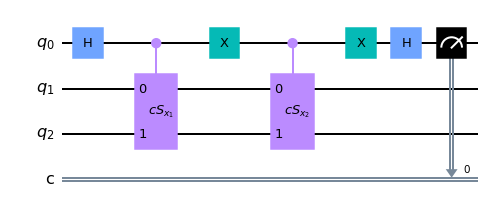

In [20]:
kernelCirc([0, 0], [1, 1], MyZFeatureMap).draw('mpl')

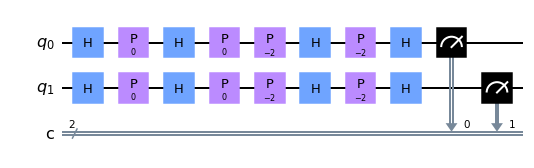

In [21]:
kernelCirc2([0, 0], [1, 1], MyZFeatureMap).draw('mpl')

# Verfication Of Dot Product Circuit

$$
\begin{align}
|\psi_0 \rangle &= |000\rangle \\
|\psi_1 \rangle &= \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) |00\rangle \\
|\psi_2 \rangle &= \frac{1}{\sqrt{2}}(|000\rangle + |1\rangle |\phi(x_1)\rangle ) \\
|\psi_3 \rangle &= \frac{1}{\sqrt{2}}(|100\rangle + |0\rangle |\phi(x_1)\rangle ) \\
|\psi_4 \rangle &= \frac{1}{\sqrt{2}}(|1\rangle |\phi(x_2)\rangle + |0\rangle |\phi(x_1)\rangle ) \\
|\psi_5 \rangle &= \frac{1}{\sqrt{2}}(|0\rangle |\phi(x_2)\rangle + |1\rangle |\phi(x_1)\rangle ) \\
|\psi_6 \rangle &= \frac{1}{2}((|0\rangle + |1\rangle)|\phi(x_2)\rangle + (|0\rangle - |1\rangle)|\phi(x_1)\rangle ) \\
&= \frac{1}{2}(|0\rangle (|\phi(x_1)\rangle + |\phi(x_2)\rangle) + |1\rangle (|\phi(x_2)\rangle - |\phi(x_1)\rangle))
\end{align}
$$

# Attempts At Gram Matrix

## Ground Truth

In [25]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance, aqua_globals

seed = 123

feature_map = ZZFeatureMap(feature_dimension=feature_dim)
qsvm = QSVM(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

Testing success ratio: 0.7


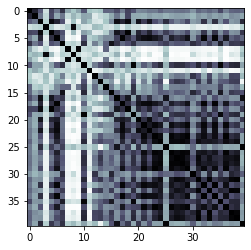

In [26]:
print(f'Testing success ratio: {result["testing_accuracy"]}')

kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r')

## Kernel Method 1

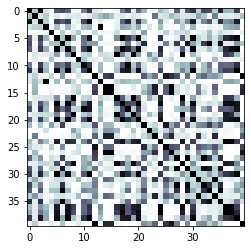

In [37]:
K = computeGramMatrix(x, MyZZFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

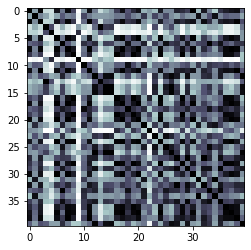

In [38]:
K = computeGramMatrix(x, MyZFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

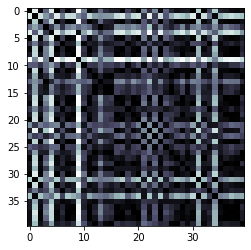

In [39]:
K = computeGramMatrix(x, MyRyFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

## Kernel Method 2

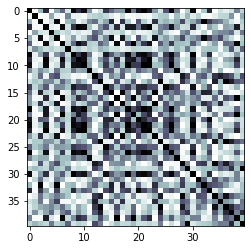

In [32]:
K = computeGramMatrix2(x, MyZZFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

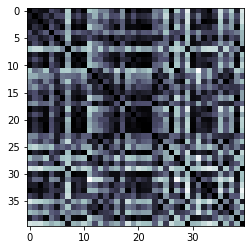

In [26]:
K = computeGramMatrix2(x, MyZFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

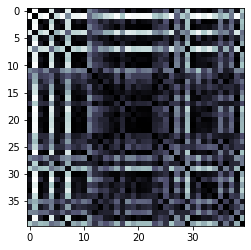

In [33]:
K = computeGramMatrix2(x, MyRyFeatureMap, shots=1024)
plt.imshow(np.asmatrix(K), interpolation='nearest', origin='upper', cmap='bone_r')

## Testing if the dot product circuit of feature map is incorrect

In [27]:
# SVM needed imports
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance, aqua_globals

seed = 123

In [32]:
class _ZZFeatureMap(FeatureMap):
    
    def __init__(self, num_qubits=1, feature_dimension=1, support_parameterized_circuit=False):
        super().__init__()
        self._num_qubits = num_qubits
        self._feature_dimension = feature_dimension
        self._support_parameterized_circuit = support_parameterized_circuit=False
    
    def construct_circuit(self, x, qr=None, inverse=False):
        if np.sum(np.iscomplex(x)) != 0:
            raise Exception("x must be real in this feature map encoding")
        
        if qr is None:
            qr = QuantumRegister(self.num_qubits)
        circ = QuantumCircuit(qr) # Input quantum register

        if inverse:
            for i in reversed(range(self.num_qubits-1)):
                circ.cx(qr[i], qr[i+1])
                circ.p(-2*(np.pi-x[i])*(np.pi-x[i+1]), qr[i+1])
                circ.cx(qr[i], qr[i+1])

            for i in range(self.num_qubits):
                circ.p(-2*x[i], qr[i])
                circ.h(qr[i])
            return circ

        for i in range(self.num_qubits):
            circ.h(qr[i])
            circ.p(2*x[i], qr[i])

        for i in range(self.num_qubits-1):
            circ.cx(qr[i], qr[i+1])
            circ.p(2*(np.pi - x[i])*(np.pi - x[i+1]), qr[i+1])
            circ.cx(qr[i], qr[i+1])

        return circ

In [35]:
feature_map = _ZZFeatureMap(num_qubits=2,  feature_dimension=feature_dim)#MyZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

C:\Users\coleb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
                The <class '__main__._ZZFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  


Testing success ratio: 0.85


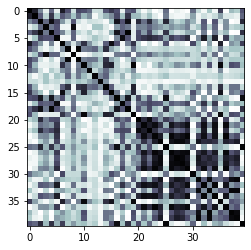

In [36]:
print(f'Testing success ratio: {result["testing_accuracy"]}')

kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r')